In [1]:
from main import *
from hyperparameter import *
from transferlearning import *

# Preprocessing

## Set the paths based on your Drive directory

In [2]:
data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')
print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: data
Training directory: data/Training
Testing directory: data/Testing


In [3]:
train_images_dir

'data/Training'

## Preprocessing


### Don't touch this block

In [4]:
# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Data visualization

## Visualizing 15 random samples

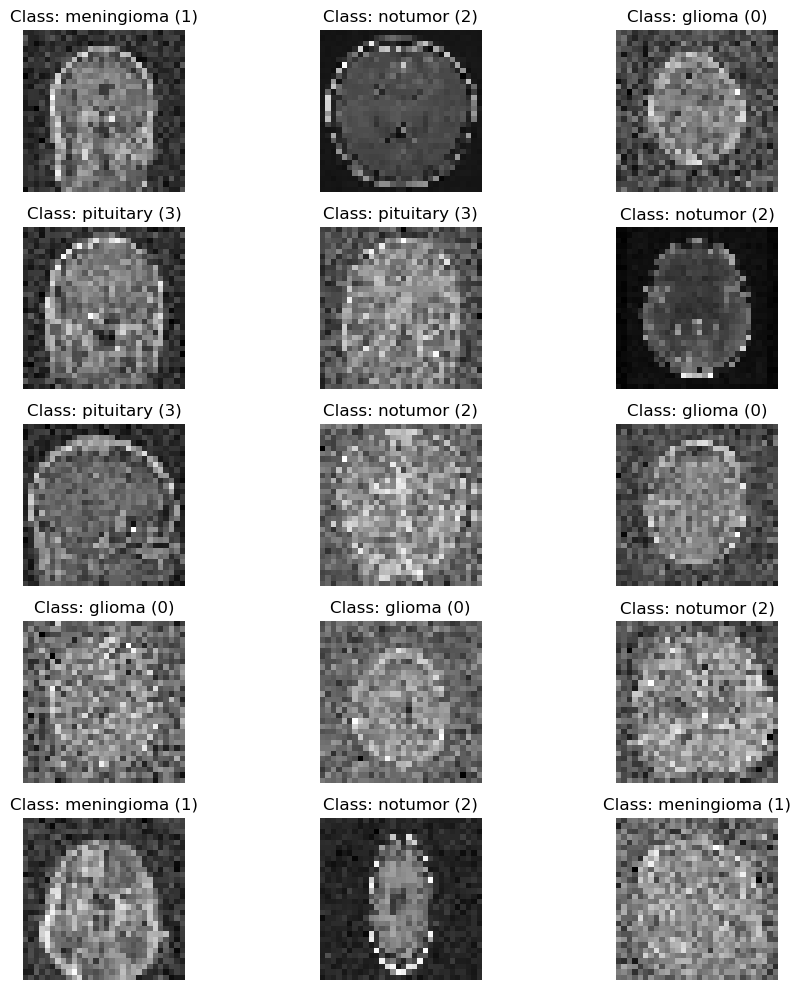

In [5]:
visualize_batch(train_data)

## Visualizing class distribution

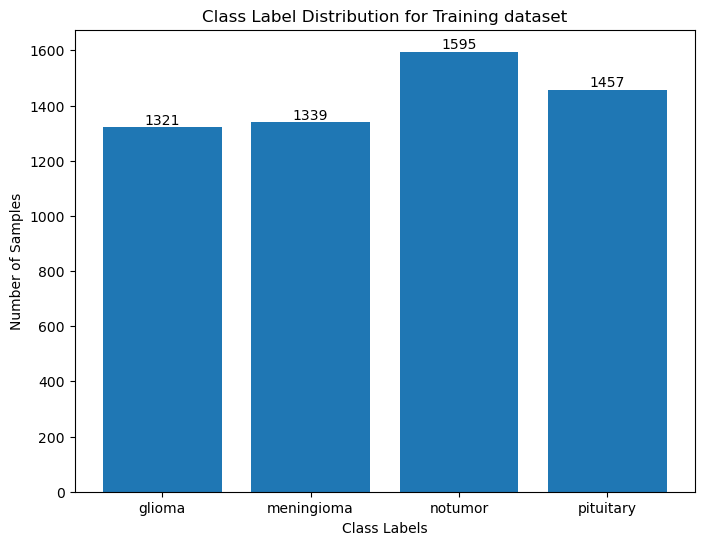

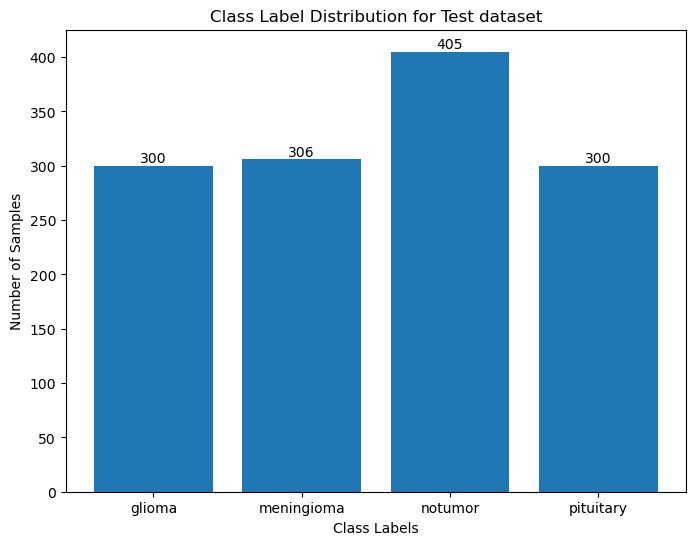

In [6]:
plot_class_distribution(train_data, test_data)

# Training, validation, and test set

In [7]:
X_train, y_train, X_val, y_val = train_val_split(train_data)
X_test, y_test = test_splits(test_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35



2024-09-27 00:57:01.290938: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-09-27 00:57:01.290964: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-09-27 00:57:01.290974: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-09-27 00:57:01.290986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-27 00:57:01.290996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)
Number of batches in the test data: 41
Batch size of a single batch 32
Number of samples in the test dataset 1311

Shape of image test set: (1311, 30, 30, 1)

Shape of label test set: (1311, 4)


# Baseline Model

In [8]:
class_names_train = list(train_data.class_indices.keys())
class_names_test = list(test_data.class_indices.keys())

In [9]:
base = baseline()
history = base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10


2024-09-27 00:57:02.738676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - F1Score: 0.4011 - accuracy: 0.4381 - loss: 1.1887 - precision: 0.6092 - recall: 0.1507 - val_F1Score: 0.6660 - val_accuracy: 0.6739 - val_loss: 0.8520 - val_precision: 0.7557 - val_recall: 0.5661
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - F1Score: 0.7096 - accuracy: 0.7188 - loss: 0.7491 - precision: 0.7919 - recall: 0.6259 - val_F1Score: 0.7153 - val_accuracy: 0.7219 - val_loss: 0.7140 - val_precision: 0.7847 - val_recall: 0.6404
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - F1Score: 0.7593 - accuracy: 0.7685 - loss: 0.6298 - precision: 0.8117 - recall: 0.7065 - val_F1Score: 0.7358 - val_accuracy: 0.7437 - val_loss: 0.6565 - val_precision: 0.7981 - val_recall: 0.6984
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - F1Score: 0.7840 - accuracy: 0.7922 - loss: 0.5686 - precision: 0.8282 - recall: 0.7464 - val_F1Score: 0.7500 - val_accuracy: 0.7563 - val_loss: 0.6239 - val_precision: 0.7931 - val_recall: 0.7120
Epoch 5

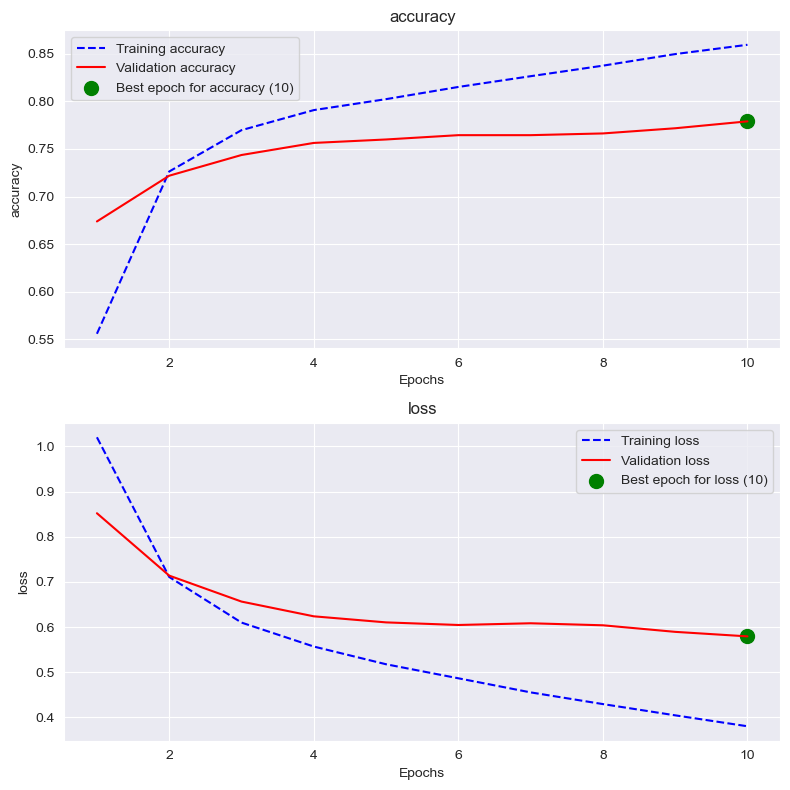

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


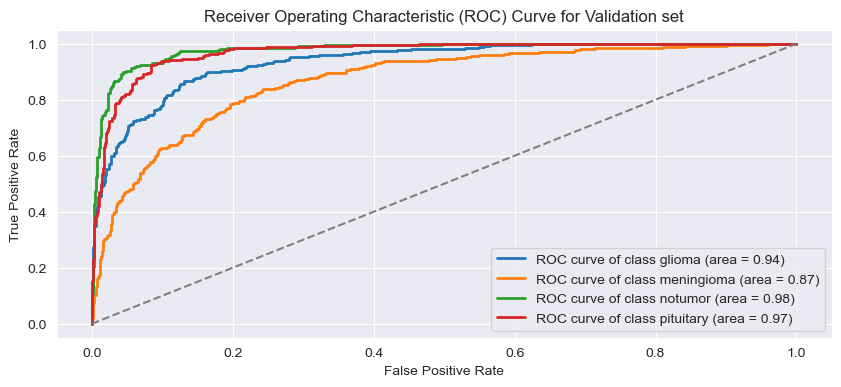

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


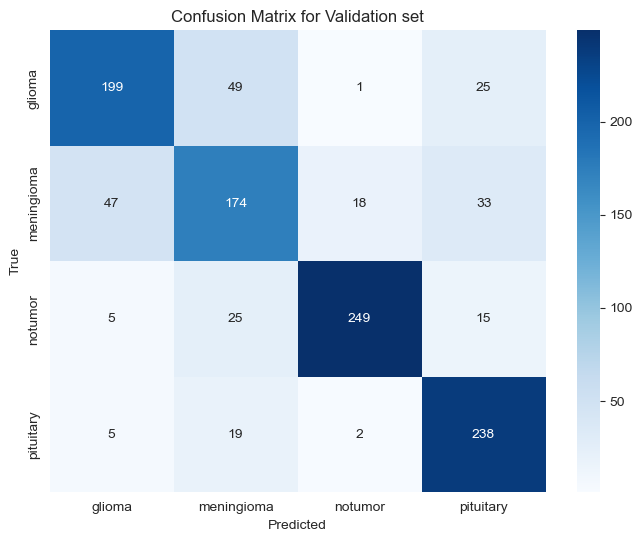

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


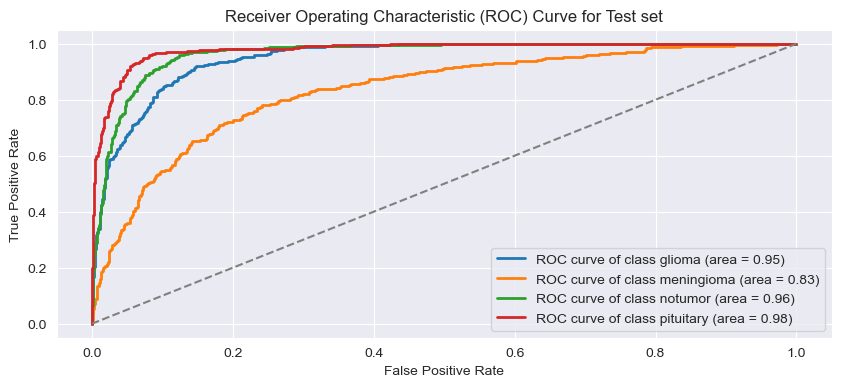

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


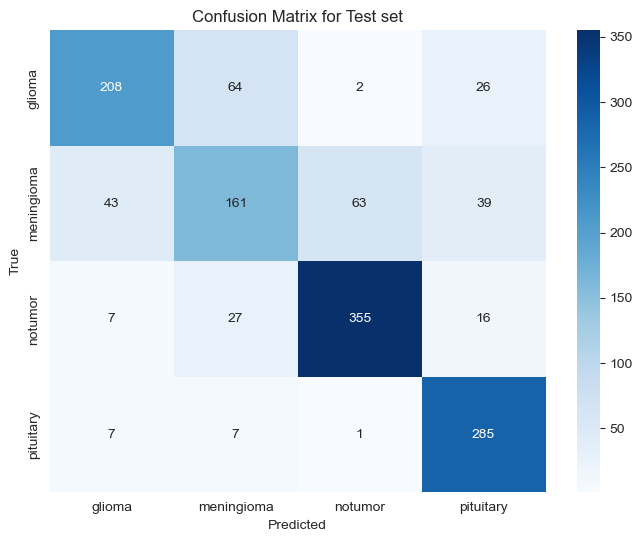

In [10]:
summarize_metric(history)

plot_roc_curve(base, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(base, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')

plot_roc_curve(base, X_test, y_test, class_names_test, title = 'Test set')
plot_confusion_matrix(base, X_test, y_test, class_names_test, normalize=False, title = 'Test set')


In [11]:
models = [base]

metrics, f1 = get_metrics(models, X_test, y_test, class_names_test)
display(metrics.rename(columns = {0: "Baselinemodel"}))
display(f1.rename(columns = {0: "F1"}))

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - F1Score: 0.4553 - accuracy: 0.6995 - loss: 0.7217 - precision: 0.7173 - recall: 0.6683


,Baselinemodel
accuracy,0.769642
precision,0.790622
recall,0.745995


,F1
glioma,0.736283
meningioma,0.569911
notumor,0.859564
pituitary,0.855856


# Hyper parameter tuning
dense units, filters, kernels, max pooling, activation, LR are all tuneable

# Transfer learning

## VGG16

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


# vgg16 expects (224,224,3) input. Minimum input is (32,32,3) but it will not generate good features
vgg16_resolution = 224 

# initialize VGG16 model and make it non trainable. Don't get the last FC layer by setting include_top to false
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(vgg16_resolution,vgg16_resolution,3))
base_model.trainable = False 

# initialise model 
vgg16_model = Sequential()
# add vgg16 compliant input
vgg16_model.add(Input(shape = (vgg16_resolution, vgg16_resolution, 1)))

# change our image to 224x224
vgg16_model.add(layers.Lambda(lambda x: tf.image.resize(x, (vgg16_resolution, vgg16_resolution)))) 

# change image to rgb
vgg16_model.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))

# add vgg16 model 
vgg16_model.add(base_model)

# add as many FC layers as needed with dropout to prevent overfitting 
vgg16_model.add(layers.Flatten())
# vgg16_model.add(layers.Dense(128, activation='relu')) 
# Added L2 regularization and batch normalization
vgg16_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# vgg16_model.add(layers.BatchNormalization()) <-- does not seem to have positive impact
vgg16_model.add(layers.Dropout(0.3))
vgg16_model.add(layers.Dense(64, activation='relu')) # only one 64 unit layer results were: accuracy: 0.7567 - loss: 0.5959 - val_accuracy: 0.6993 - val_loss: 0.7358
# vgg16_model.add(layers.BatchNormalization()) <-- does not seem to have positive impact
vgg16_model.add(layers.Dense(4, activation='softmax'))

# compile model 
vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# add early stopping if accuracy does not change for 3 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)

# fit the model 
vgg16_model.fit(X_train, y_train, epochs=1, validation_data = (X_val, y_val), batch_size=32, callbacks=[early_stopping])


# We need to add code here for the ROC curve with AUC score, performance measures, and confusion matrix



  1/144 ━━━━━━━━━━━━━━━━━━━━ 2:50 1s/step - accuracy: 0.2812 - loss: 4.1149

KeyboardInterrupt: 

## Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# Replace vgg16 with resnet50

resnet_resolution = 224 
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(resnet_resolution,resnet_resolution,3))
base_model.trainable = False ## 

resnet_model = Sequential()
resnet_model.add(Input(shape = (resnet_resolution, resnet_resolution, 1)))
resnet_model.add(layers.Lambda(lambda x: tf.image.resize(x, (resnet_resolution, resnet_resolution)))) 
resnet_model.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))
resnet_model.add(base_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(128, activation='relu'))
resnet_model.add(layers.Dropout(0.3))
resnet_model.add(layers.Dense(64, activation='relu'))
resnet_model.add(layers.Dense(4, activation='softmax'))


resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)

resnet_model.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), batch_size=32, callbacks=[early_stopping])


## Densenet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping

# Replace vgg16 with densenet


densenet_resolution = 224
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(densenet_resolution,densenet_resolution,3))
base_model.trainable = False ## 

densenet_model = Sequential()
densenet_model.add(Input(shape = (resnet_resolution, resnet_resolution, 1)))
densenet_model.add(layers.Lambda(lambda x: tf.image.resize(x, (densenet_resolution, densenet_resolution)))) 
densenet_model.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))
densenet_model.add(base_model)
densenet_model.add(layers.Flatten())
densenet_model.add(layers.Dense(128, activation='relu'))
densenet_model.add(layers.Dense(4, activation='softmax'))


densenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)

densenet_model.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), batch_size=32, callbacks=[early_stopping])
